<a href="https://colab.research.google.com/github/CamilleGreen5/Deep_Learning_with_Python/blob/master/Noise_speech_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.io.wavfile import read
from scipy.signal import stft
import glob
from pydub import AudioSegment

In [21]:
!wget https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-5.1-2020-06-22/fr.tar.gz

--2020-09-11 13:28:17--  https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-5.1-2020-06-22/fr.tar.gz
Resolving voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com (voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com)... 52.218.228.43
Connecting to voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com (voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com)|52.218.228.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16959458032 (16G) [application/octet-stream]
Saving to: ‘fr.tar.gz’

fr.tar.gz           100%[===================>]  15.79G  22.2MB/s    in 12m 39s 

2020-09-11 13:40:57 (21.3 MB/s) - ‘fr.tar.gz’ saved [16959458032/16959458032]



In [24]:
!tar -xf fr.tar.gz

In [ ]:
!ls cv-corpus-5.1-2020-06-22/fr/clips

In [43]:
list_mp3_files = glob.glob("./cv-corpus-5.1-2020-06-22/fr/clips/*.mp3")
print(list_mp3_files[:20])

['./cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_18240333.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_19862839.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_22131171.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_18191769.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_21979155.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_18019912.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_19993741.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_17997469.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_17352112.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_17838836.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_18013646.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_19753103.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_19763981.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_18384036.mp3', './cv-corpus-5.1-2020-06-22/fr/clips/common_voi

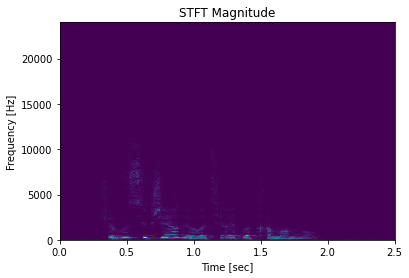

In [113]:
for path_to_mp3_file in list_mp3_files[1:2]:
    loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
    array_sound = np.array(loaded_file.get_array_of_samples(), np.float32)
    # plt.plot([i for i  in range(len(array_sound))], array_sound)

    # add random noise

    mean = np.mean(array_sound, axis=0)
    std = np.std(array_sound)
    # array_sound -= mean
    # array_sound /= std
    f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
    array_abs_stft = np.abs(array_stft)
    plt.pcolormesh(t, f, array_abs_stft)
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
